In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,  confusion_matrix, roc_curve, auc
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import plotly.express as px
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import plotly.graph_objects as go
from tabulate import tabulate
from joblib import dump, load
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as imbPipeline



import warnings
warnings.filterwarnings("ignore")

# The dataset

In [3]:
X = np.load('data/emnist_hex_images.npy')
y = np.load('data/emnist_hex_labels.npy')




## DATA EXPLORATION

Below we can see the dataset and how and some few examples from each of them. 

![Skjermbilde 2023-11-24 kl. 13.34.12.png|500](<attachment:Skjermbilde 2023-11-24 kl. 13.34.12.png>)
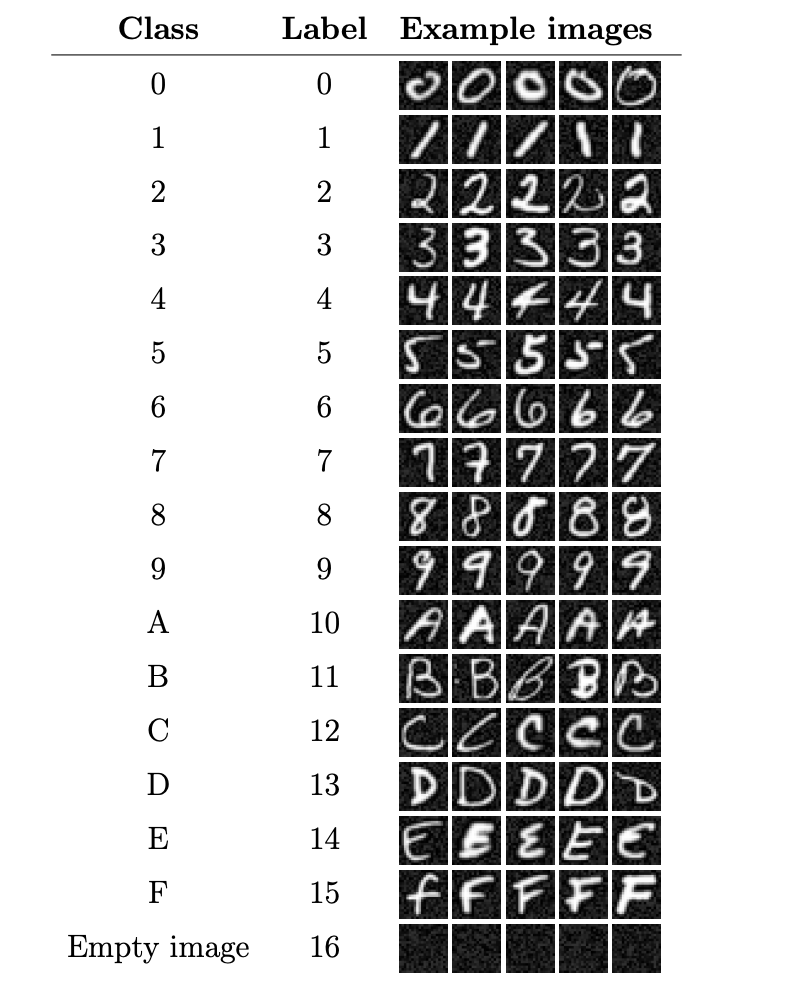

class_distribution(y):

uses plotly.express bar method to visualize how many images are in each label

In [4]:
data = pd.Series(y).value_counts().sort_index()
fig = px.bar(data, labels= {'value': 'total in dataset', 'index': 'digit'}, title= 'Class Distribution')
fig.update_xaxes(tickvals= list(range(0, 17)))
fig.show()

This cell uses plotly express and pandas to visualize the frequency of different pixel values in the images. This was done to see how many gray pixels there are in the dataset, so we could consider modifying them. 
First we converted the numpy array to a pandas dataframe. Then we could create a column for each pixel value, 1 to 400 and then use numpy bincount to count the occurences of the different values. And at last, create a easy to understand plot. 


In [5]:
XX = pd.DataFrame(X, columns = [str(i) for i in range(400)])
value_counts = np.bincount(XX.values.flatten())

df_plot = pd.DataFrame({'Pixel Value': range(len(value_counts)), 'Frequency': value_counts})

color1 = px.colors.qualitative.Dark2[7]
color2 = px.colors.qualitative.Dark2[6]
color3 = px.colors.qualitative.Dark2[5]
color_map = {
    'Pixel Value < 100': color1,
    'Pixel Value between 100 and 254': color2,
    'Pixel Value > 254': color3
}
color_categories = pd.cut(df_plot['Pixel Value'],
                           bins=[-np.inf, 100, 254, np.inf],
                           labels=['Pixel Value < 100', 'Pixel Value between 100 and 254', 'Pixel Value > 254'],
                           include_lowest=True)

fig = px.bar(df_plot, x='Pixel Value', y='Frequency', 
            title='Frequency of Pixel Values in the Dataset',
            labels={'Pixel Value': 'Pixel Value (0-255)', 'Frequency': 'Frequency'},
            log_y = True,
            color=color_categories,
            color_discrete_map=color_map)
fig.update_layout(height=600)

fig.show()

Split the data into 80% train data, 10% validation data and 10% train data. Define random_state for reproducibility

In [6]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state=123)


label_errors(y_test, y_pred):
A function for visualizing the presicion and recall values for each class

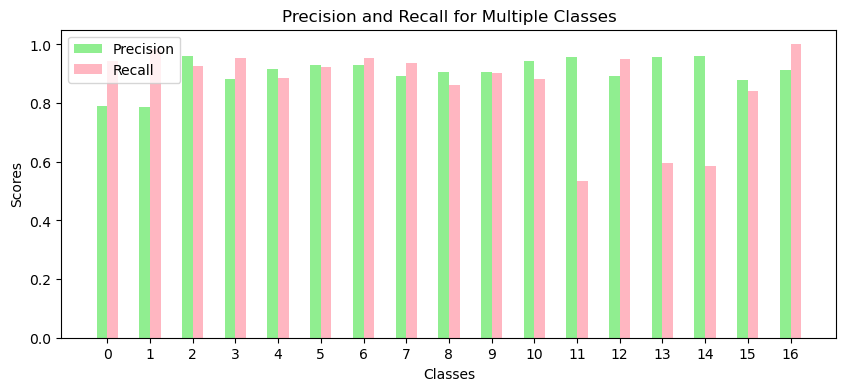

In [7]:
def label_errors(y_test, y_pred):
    classes = list(range(0, 17))
    presicion = [precision_score(y_test, y_pred, labels= [n], average= 'micro') for n in classes]
    recall = [recall_score(y_test, y_pred, labels= [n], average= 'micro') for n in classes]
    fig, ax = plt.subplots(figsize=(10, 4))

    
    bar_width = 0.25

    x = range(len(classes))

    #bar plots for precision and recall
    precision_bars = ax.bar(x, presicion, width=bar_width, label='Precision', align='center', color= 'lightgreen')
    recall_bars = ax.bar([i + bar_width for i in x], recall, width=bar_width, label='Recall', align='center', color = 'lightpink')

    ax.set_xticks([i + bar_width/2 for i in x])
    ax.set_xticklabels(classes)

    ax.set_xlabel('Classes')
    ax.set_ylabel('Scores')
    ax.set_title('Precision and Recall for Multiple Classes')
    ax.legend(loc='best')

    plt.show()

model = KNeighborsClassifier()

model.fit(X_train[-10000:], y_train[-10000:])
y_pred = model.predict(X_train[:10000])

label_errors(y_train[:10000], y_pred)

pred_distrb(y_test, y_pred):

a function which plots a confusion matrix for input target values and predicted values. 

error_distrb(y_test, y_pred):
a function which plots a bar diagram to visualize the amount of errors for each label. 


In [8]:
def pred_distrb(y_test, y_pred, min= 0, max= 17):
    matrix = confusion_matrix(y_test, y_pred)
    matrix = matrix.astype(int)

    layout = {
        "title": "Prediction distribution", 
        "xaxis": {"title": "Predicted digit"}, 
        "yaxis": {"title": "Real digit"}
    }

    fig = go.Figure(data=go.Heatmap(z=matrix,
                                    x= list(range(0, 17)),
                                    y= list(range(min, max)),
                                    hoverongaps=False,
                                    colorscale = 'gnbu',
                                    colorbar = dict(title = 'Count'),
                                    text = matrix,
                                    showscale = True),
                    layout=layout)
    fig.update_xaxes(tickvals= list(range(0, 17)))
    fig.show()

def error_distrb(y_test, y_pred):
    wrong = y_test[np.argwhere(y_pred != y_test).flatten()]
    data = pd.Series(wrong).value_counts().sort_index()
    fig = px.bar(data, labels= {'value': 'number of erros', 'index': 'digit'}, title= 'error distribution')
    fig.update_xaxes(tickvals= list(range(0, 17)))
    fig.show()

In [9]:
pred_distrb(y_train[:10000], y_pred)
error_distrb(y_train[:10000], y_pred)

# Defining the DigitClassifier Class

denoise(image):
a function to denoise an image. It changes all pixel values under 100 to 0, and pixel values 254 to 255. 


In [10]:
def denoise(image):
    mask_255 = image >= 254
    mask_0 = (image < 100)

    image[mask_255] = 255
    image[mask_0] = 0
    
    
    return image

A class we needed to create in order to implement the denoise function inside the pipeline.

In [11]:
class Denoise(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
        
    
    def transform(self, X):
        # Apply denoise function to each image in X
        for i in range(len(X)):
            X[i] = denoise(X[i])
        return X


Our DigitClassifier class for hyperparameter-tuning and cross-validation. Is initialized with the input of a classifier model, a scaler and chosen hyperparameters for the model.

grid_search_pipe(self, X_train, y_train, pipeline= None):
    performs a grid search of the pipeline, performs the pipeline steps, and cross validates with the hyperparameters.
    returns the best model, what score it got, and what parameters it had. 

train(self, X_train, y_train):
    creates the pipeline
    calls on grid_search pipe
    prints its results
    returns the best model

test(self, X_test, y_test):
    tests the best model from train on the validation data. 
    also prints different performance measures


In [12]:
class DigitClassifier:
    
    def __init__(self, model, scaler, params):
        self.model = model
        self.scaler = scaler
        self.params = params
        self.best_model = None
        self.val_score = None
        self.best_params = None
    
    def grid_search_pipe(self, X_train, y_train, pipeline=None):

        grid = GridSearchCV(pipeline, self.params, cv=4, n_jobs=-1, verbose=3)
        grid.fit(X_train, y_train)

        return grid.best_estimator_, grid.best_score_, grid.best_params_
        
    def train(self, X_train, y_train):

        ros = RandomOverSampler()

        pipeline_steps = [
            ('oversampler', ros),
            ('denoise', Denoise()),
            ('scaler', self.scaler),
            ('model', self.model)
        ]

        
        pipeline = imbPipeline(pipeline_steps)
        
        best_model, best_score, best_params = self.grid_search_pipe(X_train, y_train, pipeline)
        
        denoise_name = type(Denoise()).__name__
        oversampler = type(ros).__name__
        scaler_name = type(self.scaler).__name__
        model_name = type(self.model).__name__ 
        print(f'Our best model: ({model_name}, oversampler: {oversampler}, denoise {denoise_name}), and scaler ({scaler_name}) )\nBest hyperparameters: {best_params}\nCV score: {best_score}')
            
        if (self.best_model is None) or best_score > self.best_model[1]:     
            self.best_model = (best_model, best_score)
            self.best_params = best_params
                
        return self.best_model

        
    def test(self, X_test, y_test):
        y_pred = self.best_model[0].predict(X_test)
        self.val_score = accuracy_score(y_test, y_pred)
        
    
        scores = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='weighted'),
            'Recall': recall_score(y_test, y_pred, average='weighted'),
            'F1 Score': f1_score(y_test, y_pred, average='weighted')
        }
        
        data = [(name, val) for name, val in scores.items()]
        print('Score on val data:')
        print(tabulate(data, headers=['Metric', 'Score'], tablefmt='github'))
    
    def y_pred(self):
        return self.best_model[0].predict(X_test)
    



Our class RunModels for implementing the DigitClassifier class for each classifier we want to use. We create a method for each classifier. 

KNN, RFC and SVC_ all call on the DigitClassifier class with train and validation data for hyperparamter-tuning. 

run_best_model(self, X_test, y_test):
It checks which of the 3 best models from the classifiers performs best on the validation data. The model with the best results is then tested on the test data. It prints the final results. 


In [26]:

class RunModels:
    def __init__(self, X_train, y_train, X_val, y_val, models = ['RFC', 'KNN', 'SVC']):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.models = models
        self.y_pred = None
        self.best_model = None
        
        
    def KNN(self, neighbors = [5, 9, 13, 15], weights = ['uniform', 'distance'], p = [1, 2]):
        model = KNeighborsClassifier()
        params = {
            'model__n_neighbors': neighbors,
            'model__weights': weights,
            'model__p' : p
        }
        scalers = StandardScaler()

     
        knn = DigitClassifier(model, scalers, params)


        knn.train(self.X_train, self.y_train)

        knn.test(self.X_val, self.y_val)
        dump(knn, 'KNN.joblib')


    def RFC(self, estimators = [1000], criterion = ['gini', 'entropy'], max_features=[0.3, 'sqrt', 'log2']):

        model = RandomForestClassifier(max_depth=None, min_samples_split=2, random_state=42)
        params = {
            'model__n_estimators': estimators,
            'model__criterion': criterion,
            'model__max_features' : max_features
        }
        scalers = StandardScaler()


        rfc = DigitClassifier(model, scalers, params)


        rfc.train(self.X_train, self.y_train)

        rfc.test(self.X_val, self.y_val)
        dump(rfc, 'RFC.joblib')

    def SVC_(self, C = [1, 3], gamma = ['scale', 'auto'], kernel = ['rbf', 'poly']):
        model = SVC(cache_size=1000)
        params = {
            'model__C': C,
            'model__gamma': gamma,
            'model__kernel': kernel,
        }

        scalers = StandardScaler()

        svc = DigitClassifier(model, scalers, params)

        svc.train(self.X_train, self.y_train)

        svc.test(self.X_val, self.y_val)
        dump(svc, 'SVC.joblib')


    def run_best_model(self, X_test, y_test):
        best_accuracy = 0
        output = []
        for i in self.models:
            data = load(i + '.joblib')
            score = data.val_score
            output.append([i, score])
            if score > best_accuracy:
                best_accuracy = score
                self.best_model = i
                params = data.best_params
            
        print(tabulate(output, headers=['Model', 'Score'], tablefmt='github'))
        print()
        print(f'Our best model: {self.best_model}\nHyperparameters: {params}')
        

        y_pred = load(self.best_model + '.joblib').best_model[0].predict(X_test)
        self.y_pred = y_pred
        print(f'Our best model´s accuracy on test data: {accuracy_score(y_test, y_pred)}')

        dump(y_pred, 'best_model.joblib')

    

In [27]:
run_models = RunModels(X_train, y_train, X_val, y_val)

In [23]:


run_models.KNN()

Fitting 4 folds for each of 16 candidates, totalling 64 fits


[CV 1/4] END model__n_neighbors=5, model__p=2, model__weights=uniform;, score=0.861 total time=  40.2s
[CV 2/4] END model__n_neighbors=5, model__p=2, model__weights=uniform;, score=0.856 total time=  40.4s
[CV 4/4] END model__n_neighbors=5, model__p=2, model__weights=uniform;, score=0.855 total time=  40.3s
[CV 3/4] END model__n_neighbors=5, model__p=2, model__weights=uniform;, score=0.860 total time=  40.5s
[CV 1/4] END model__n_neighbors=5, model__p=2, model__weights=distance;, score=0.866 total time=  39.8s
[CV 2/4] END model__n_neighbors=5, model__p=2, model__weights=distance;, score=0.863 total time=  39.8s
[CV 3/4] END model__n_neighbors=5, model__p=2, model__weights=distance;, score=0.865 total time=  39.7s
[CV 4/4] END model__n_neighbors=5, model__p=2, model__weights=distance;, score=0.859 total time=  39.8s
[CV 4/4] END model__n_neighbors=5, model__p=1, model__weights=distance;, score=0.907 total time= 9.5min
[CV 3/4] END model__n_neighbors=5, model__p=1, model__weights=unifor

run_models.SVC_()

In [24]:
run_models.RFC()

Fitting 4 folds for each of 6 candidates, totalling 24 fits
[CV 2/4] END model__criterion=gini, model__max_features=log2, model__n_estimators=1000;, score=0.941 total time= 2.4min
[CV 1/4] END model__criterion=gini, model__max_features=log2, model__n_estimators=1000;, score=0.941 total time= 2.4min
[CV 4/4] END model__criterion=gini, model__max_features=log2, model__n_estimators=1000;, score=0.937 total time= 2.4min
[CV 3/4] END model__criterion=gini, model__max_features=log2, model__n_estimators=1000;, score=0.938 total time= 2.4min
[CV 2/4] END model__criterion=gini, model__max_features=sqrt, model__n_estimators=1000;, score=0.943 total time= 4.9min
[CV 1/4] END model__criterion=gini, model__max_features=sqrt, model__n_estimators=1000;, score=0.943 total time= 5.0min
[CV 4/4] END model__criterion=gini, model__max_features=sqrt, model__n_estimators=1000;, score=0.940 total time= 5.0min
[CV 3/4] END model__criterion=gini, model__max_features=sqrt, model__n_estimators=1000;, score=0.941

In [28]:
best_model = run_models.run_best_model(X_test, y_test)
best_model

| Model   |    Score |
|---------|----------|
| RFC     | 0.944718 |
| KNN     | 0.914479 |
| SVC     | 0.958724 |

Our best model: SVC
Hyperparameters: {'model__C': 3, 'model__gamma': 'auto', 'model__kernel': 'poly'}
Our best model´s accuracy on test data: 0.9603896103896103


### Plots on our best model

In [29]:
best_y_pred = load('best_model.joblib')
pred_distrb(y_test, best_y_pred)

In [30]:
error_distrb(y_test, best_y_pred)

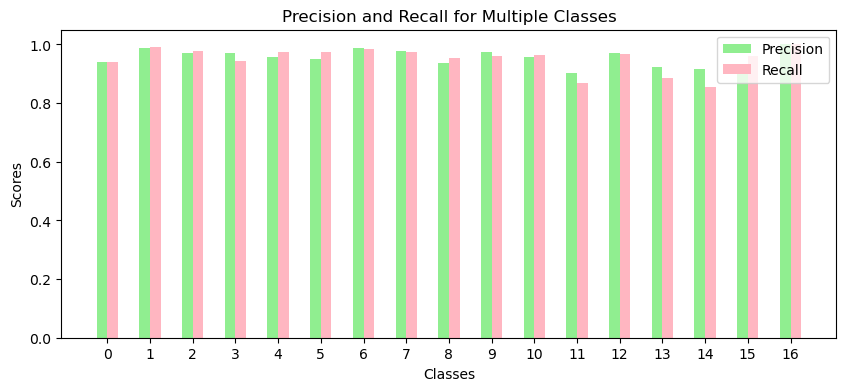

In [31]:
label_errors(y_test, best_y_pred)

## Final thoughts

So what can we learn from this? We have seen that still after oversampling the underrepresented classes, class 11 and 13 (B and D) still get a lot of errors. We have concluded that this is because of the bad data that is in these classes. When random oversampling them, we still reproduce the bad samples from these classes. We will show you some examples below.

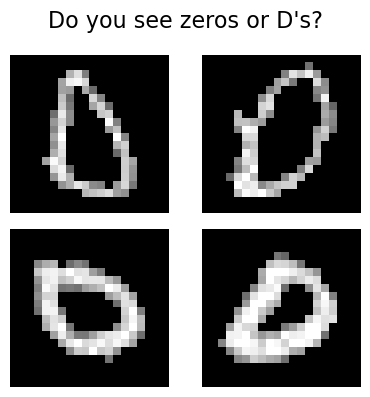

In [32]:
l = []
for i in range(1, 5000):
    if y_test[i] == 13 and best_y_pred[i] == 0:
        l.append(X_test[i])

fig, axes = plt.subplots(2, 2, figsize=(4,4))

axes[0,0].imshow(l[0].reshape(20,20), vmin=0, vmax=255, cmap='gray')
axes[0,0].axis('off')

axes[0,1].imshow(l[1].reshape(20,20), vmin=0, vmax=255, cmap='gray')
axes[0,1].axis('off')

axes[1,0].imshow(l[3].reshape(20,20), vmin=0, vmax=255, cmap='gray')
axes[1,0].axis('off')

axes[1,1].imshow(l[4].reshape(20,20), vmin=0, vmax=255, cmap='gray')
axes[1,1].axis('off')

fig.suptitle("Do you see zeros or D's?", fontsize=16)
plt.tight_layout()
plt.show()

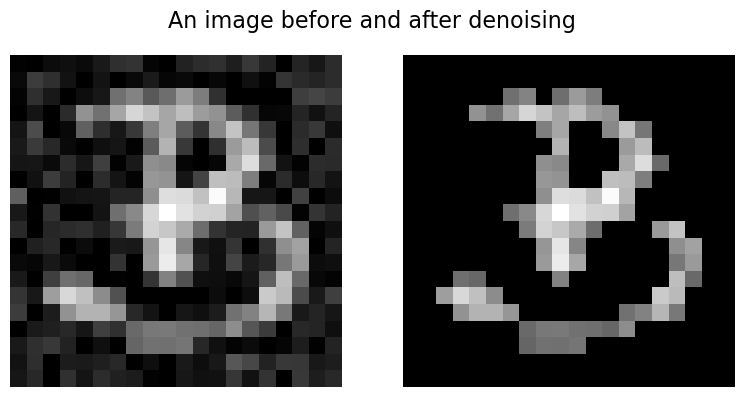

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))


axes[0].imshow(X[10000].reshape(20,20), vmin=0, vmax=255, cmap='gray')
axes[0].axis('off')


axes[1].imshow(denoise(X[10000]).reshape(20,20), vmin=0, vmax=255, cmap='gray')
axes[1].axis('off')






fig.suptitle("An image before and after denoising", fontsize=16)
plt.tight_layout()
plt.show()